In [6]:
# ─── 正式代码开始 ───
from pathlib import Path
from typing import List, Tuple
import numpy as np
import pandas as pd
import yfinance as yf
import ta  # technical analysis indicators

# ──────────────────────────────── 参数设置 ────────────────────────────────
tickers = [
    "AAPL", "MSFT", "AMZN", "GOOGL", "META",
    "TSLA", "NVDA", "NFLX", "ORCL", "INTC",
    "AMD", "CRM", "ADBE", "QCOM", "CSCO",
    "PYPL", "UBER", "SHOP", "BA", "DIS"
]
start = "2015-01-01"
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True, parents=True)


# ──────────────────────────────── 工具函数 ────────────────────────────────
def fetch_prices(tickers: List[str], start: str = "2015-01-01", end: str | None = None) -> pd.DataFrame:
    df_raw = yf.download(
        tickers=tickers,
        start=start,
        end=end,
        auto_adjust=False,
        progress=False,
        group_by="ticker",

    )

    records = []
    for ticker in tickers:
        if ticker not in df_raw.columns.levels[0]:
            print(f"⚠️  {ticker}: no data downloaded, skipping.")
            continue
        dfi = df_raw[ticker].copy()
        dfi["ticker"] = ticker
        records.append(dfi.reset_index())

    df = pd.concat(records)
    df.columns = [c.lower() for c in df.columns]
    df.rename(columns={"adj close": "adj_close"}, inplace=True)
    return df[["date", "ticker", "open", "high", "low", "close", "adj_close", "volume"]].sort_values("date")


def add_technical_features(df: pd.DataFrame) -> pd.DataFrame:
    out = []
    for tkr, grp in df.groupby("ticker", sort=False):
        g = grp.sort_values("date").copy()

        g["ret1d"] = np.log(g["close"].pct_change() + 1)
        g["ret5d"] = np.log(g["close"].pct_change(5) + 1)

        g["ma5"] = g["close"].rolling(5).mean()
        g["ma20"] = g["close"].rolling(20).mean()
        g["ema12"] = g["close"].ewm(span=12, adjust=False).mean()
        g["ema26"] = g["close"].ewm(span=26, adjust=False).mean()

        g["macd"] = g["ema12"] - g["ema26"]
        g["macd_signal"] = g["macd"].ewm(span=9, adjust=False).mean()

        g["rsi14"] = ta.momentum.rsi(g["close"], window=14, fillna=False)

        bb_high = g["close"].rolling(20).mean() + 2 * g["close"].rolling(20).std()
        bb_low = g["close"].rolling(20).mean() - 2 * g["close"].rolling(20).std()
        g["bb_mid"] = (bb_high + bb_low) / 2
        g["bb_width"] = (bb_high - bb_low) / g["close"]

        g["volatility20d"] = g["ret1d"].rolling(20).std() * np.sqrt(252)
        g["volume_z"] = (g["volume"] - g["volume"].rolling(20).mean()) / g["volume"].rolling(20).std()

        g["obv"] = ta.volume.on_balance_volume(g["close"], g["volume"], fillna=False)

        out.append(g)

    feat = pd.concat(out).dropna().reset_index(drop=True)
    return feat


def train_val_test_split(df: pd.DataFrame, ratios: Tuple[float, float, float] = (0.3, 0.3, 0.4)) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    assert abs(sum(ratios) - 1.0) < 1e-6, "ratios must sum to 1"
    unique_dates = df["date"].sort_values().unique()
    n = len(unique_dates)
    n_train = int(n * ratios[0])
    n_val = int(n * ratios[1])

    train_dates = unique_dates[:n_train]
    val_dates = unique_dates[n_train : n_train + n_val]
    test_dates = unique_dates[n_train + n_val :]

    train = df[df["date"].isin(train_dates)].reset_index(drop=True)
    val   = df[df["date"].isin(val_dates)].reset_index(drop=True)
    test  = df[df["date"].isin(test_dates)].reset_index(drop=True)
    return train, val, test


# ──────────────────────────────── 主流程 ────────────────────────────────
print("⏬  Fetching price data …")
prices = fetch_prices(tickers, start=start)
prices.to_parquet(DATA_DIR / "raw_prices.parquet", index=False)
print(f"✅  Saved raw to data/raw_prices.parquet  (rows={len(prices):,})")

print("⚙️   Computing technical indicators …")
feat = add_technical_features(prices)
feat.to_parquet(DATA_DIR / "features.parquet", index=False)
print(f"✅  Saved features to data/features.parquet  (rows={len(feat):,})")

print("🔪  Splitting train/val/test … (0.3/0.3/0.4)")
train, val, test = train_val_test_split(feat)
for name, frame in zip(["train", "val", "test"], [train, val, test]):
    path = DATA_DIR / f"features_{name}.parquet"
    frame.to_parquet(path, index=False)
    print(f"   • {name:<5}: {len(frame):,} rows → {path.name}")

print("🎉  Feature pipeline complete.")

⏬  Fetching price data …
✅  Saved raw to data/raw_prices.parquet  (rows=52,900)
⚙️   Computing technical indicators …
✅  Saved features to data/features.parquet  (rows=51,184)
🔪  Splitting train/val/test … (0.3/0.3/0.4)
   • train: 14,732 rows → features_train.parquet
   • val  : 15,432 rows → features_val.parquet
   • test : 21,020 rows → features_test.parquet
🎉  Feature pipeline complete.


In [7]:
DATA_DIR = Path("data")
H = 5  # prediction horizon (days)
def load_features(split: str) -> pd.DataFrame:
    path = DATA_DIR / f"features_{split}.parquet"
    if not path.exists():
        raise FileNotFoundError(f"Feature file {path} not found; run feature_engineering first.")
    return pd.read_parquet(path)


def label_group(g: pd.DataFrame) -> pd.DataFrame:
    """For one ticker, compute future cumulative returns and derive τ*."""
    g = g.sort_values("date").reset_index(drop=True)
    prices = g["close"].values
    # Pre-compute log returns (faster than pct_change in loop)
    log_ret = np.log(prices[1:] / prices[:-1])
    # Pad to align length
    log_ret = np.append(log_ret, np.nan)
    g["_log_ret"] = log_ret

    tau_list: List[int] = []
    payoff_list: List[float] = []
    sign_list: List[int] = []

    # Iterate up to len-H (the last H rows don't have full horizon)
    for idx in range(len(g) - H):
        # cumulative log return up to each horizon step 1..H
        future_slice = g["_log_ret"].iloc[idx : idx + H]
        cum = np.cumsum(future_slice.values)
        # convert to simple return: exp(log_return) - 1
        simple_cum = np.exp(cum) - 1.0
        # find k (1..H) that maximises absolute return
        k_star = int(np.argmax(np.abs(simple_cum)) + 1)
        payoff = float(simple_cum[k_star - 1])

        tau_list.append(k_star)
        payoff_list.append(abs(payoff))
        sign_list.append(int(np.sign(payoff)))

    # align output length
    valid = g.iloc[: len(tau_list)].copy()
    valid["tau"] = tau_list
    valid["abs_payoff"] = payoff_list
    valid["sign"] = sign_list
    return valid[["date", "ticker", "tau", "abs_payoff", "sign"]]


def generate_labels(split: str):
    df = load_features(split)
    out = []
    for tkr, grp in df.groupby("ticker", sort=False):
        out.append(label_group(grp))
    labeled = pd.concat(out).reset_index(drop=True)
    out_path = DATA_DIR / f"labels_{split}.parquet"
    labeled.to_parquet(out_path, index=False)
    print(f"✅  {split:<5} labels → {out_path.name}  (rows={len(labeled):,})")


def main():
    for split in ["train", "val", "test"]:
        generate_labels(split)

    # quick sanity check: tau distribution in train
    train_lbl = pd.read_parquet(DATA_DIR / "labels_train.parquet")
    print("\nτ* distribution (train):")
    print(train_lbl["tau"].value_counts(normalize=True).sort_index())

    print("\nDirection sign distribution (train):")
    print(train_lbl["sign"].value_counts(normalize=True))


if __name__ == "__main__":
    main()

✅  train labels → labels_train.parquet  (rows=14,637)
✅  val   labels → labels_val.parquet  (rows=15,332)
✅  test  labels → labels_test.parquet  (rows=20,920)

τ* distribution (train):
tau
1    0.084170
2    0.132677
3    0.172576
4    0.220537
5    0.390039
Name: proportion, dtype: float64

Direction sign distribution (train):
sign
 1    0.572795
-1    0.427205
Name: proportion, dtype: float64


In [8]:
from __future__ import annotations

from pathlib import Path
import joblib
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
H = 5  # horizon classes
DATA_DIR = Path("data")
MODEL_DIR = Path("models"); MODEL_DIR.mkdir(exist_ok=True, parents=True)
RANDOM_STATE = 42

# ───────────────────────────────────────────────────────── helpers ─────────────────────────────────────────────────────────

def load_split(split: str) -> pd.DataFrame:
    feat = pd.read_parquet(DATA_DIR / f"features_{split}.parquet")
    lbl  = pd.read_parquet(DATA_DIR / f"labels_{split}.parquet")
    # merge on date+ticker to align features & labels
    merged = feat.merge(lbl, on=["date", "ticker"], how="inner")
    return merged


def build_dataset(df: pd.DataFrame):
    feature_cols = df.columns.difference(["date", "ticker", "tau", "abs_payoff", "sign"])
    X = df[feature_cols].values.astype(np.float32)
    y = df["tau"].values.astype(np.int64) - 1  # classes 0..H-1
    return X, y, feature_cols


# ───────────────────────────────────────────────────────── main ─────────────────────────────────────────────────────────

def main():
    print("📥  Loading data …")
    train_df = load_split("train")
    val_df   = load_split("val")
    print(f"   • train rows: {len(train_df):,}")
    print(f"   • val   rows: {len(val_df):,}")

    X_train, y_train, feature_cols = build_dataset(train_df)
    X_val,   y_val,   _            = build_dataset(val_df)

    clf = XGBClassifier(
        objective="multi:softprob",
        num_class=H,
        n_estimators=800,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=RANDOM_STATE,
        tree_method="hist",  # fast CPU; change to 'gpu_hist' if GPU available
        eval_metric="mlogloss",
    )

    print("🧠  Training XGBoost τ-classifier …")
    clf.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False,
    )

    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"✅  Val accuracy: {acc:.3f}")
    print(classification_report(y_val, y_pred, digits=3))

    model_path = MODEL_DIR / "tau_clf.pkl"
    joblib.dump({"model": clf, "feature_cols": feature_cols.tolist()}, model_path)
    print(f"✅ Saved to {MODEL_DIR / 'tau_clf.pkl'}")

if __name__ == "__main__":
    main()


📥  Loading data …
   • train rows: 14,637
   • val   rows: 15,332
🧠  Training XGBoost τ-classifier …
✅  Val accuracy: 0.364
              precision    recall  f1-score   support

           0      0.131     0.008     0.016      1327
           1      0.146     0.031     0.051      2016
           2      0.181     0.036     0.059      2614
           3      0.228     0.069     0.105      3398
           4      0.390     0.867     0.538      5977

    accuracy                          0.364     15332
   macro avg      0.215     0.202     0.154     15332
weighted avg      0.264     0.364     0.252     15332

✅ Saved to models/tau_clf.pkl


In [9]:
"""backtest.py
===============

Rolling‐window backtest using τ̂ predictions from the trained classifier.
This **minimal version** demonstrates the mechanics **without** direction
(sign) and |R| regression yet; instead we:

1. Predict τ̂ for every (date, ticker) row in the **test** split.
2. Compute the *realised* return that would have been achieved by entering at
   day 0 and exiting at day τ̂.
3. Rank by absolute value of that realised return – as if the model perfectly
   knew the magnitude but only decided timing – and build 20‐stock long/short
   portfolios daily.

When the direction & |R| models are ready, replace the step that uses realised
returns with that model’s prediction.
"""
from __future__ import annotations

from pathlib import Path
from typing import Dict
import joblib
import numpy as np
import pandas as pd

DATA_DIR = Path("data")
MODEL_DIR = Path("models")
RESULT_DIR = Path("results"); RESULT_DIR.mkdir(exist_ok=True, parents=True)
H = 5
N_STOCK = 20

# ───────────────────────────────────────────────────────── helpers ─────────────────────────────────────────────────────────

def load_test() -> pd.DataFrame:
    feat = pd.read_parquet(DATA_DIR / "features_test.parquet")
    return feat


def predict_tau(df: pd.DataFrame, tau_model_path: Path) -> pd.Series:
    payload = joblib.load(tau_model_path)
    model = payload["model"]
    feature_cols = payload["feature_cols"]
    X = df[feature_cols].values.astype(np.float32)
    preds = model.predict(X) + 1  # back to 1..H
    return pd.Series(preds, index=df.index, name="tau_pred")


def compute_realised_payout(df: pd.DataFrame) -> pd.Series:
    """Given df with sorted date per ticker, compute realised log return from day0 to day tau_pred."""
    payout = np.zeros(len(df))
    for tkr, grp in df.groupby("ticker", sort=False):
        grp = grp.sort_values("date").reset_index()
        prices = grp["close"].values
        tau_vec = grp["tau_pred"].values.astype(int)
        for i, tau in enumerate(tau_vec):
            if i + tau >= len(prices):
                payout[grp.loc[i, "index"]] = 0.0  # skip if horizon runs past data
                continue
            log_ret = np.log(prices[i + tau] / prices[i])
            payout[grp.loc[i, "index"]] = log_ret
    return pd.Series(payout, index=df.index, name="realised")


def daily_portfolio(df: pd.DataFrame) -> pd.DataFrame:
    """Construct daily long/short portfolio weights based on realised return magnitude."""
    df["score"] = df["realised"].abs() * np.sign(df["realised"])  # just for demo
    out = []
    for date, day in df.groupby("date"):
        day = day.copy()
        long_candidates = day.nlargest(N_STOCK // 2, "score")
        short_candidates = day.nsmallest(N_STOCK // 2, "score")
        total_long = long_candidates["score"].abs().sum()
        total_short = short_candidates["score"].abs().sum()
        if total_long == 0 or total_short == 0:
            continue
        long_candidates["weight"] = long_candidates["score"].abs() / total_long
        short_candidates["weight"] = -short_candidates["score"].abs() / total_short
        pos = pd.concat([long_candidates, short_candidates])[["ticker", "weight"]]
        pos["date"] = date
        out.append(pos)
    return pd.concat(out)


def compute_daily_pnl(portfolio: pd.DataFrame, price_df: pd.DataFrame) -> pd.Series:
    ret = price_df.copy()
    ret["log_ret"] = np.log(ret["close"].pct_change() + 1)
    merged = portfolio.merge(ret[["date", "ticker", "log_ret"]], on=["date", "ticker"], how="left")
    merged["pnl"] = merged["weight"] * merged["log_ret"].fillna(0.0)
    daily_pnl = merged.groupby("date")["pnl"].sum()
    return daily_pnl


# ───────────────────────────────────────────────────────── main ─────────────────────────────────────────────────────────

def main():
    print("📥  Loading test split …")
    test_df = load_test()

    print("🔮  Predicting τ̂ …")
    test_df["tau_pred"] = predict_tau(test_df, MODEL_DIR / "tau_clf.pkl")

    print("💰  Computing realised payouts …")
    test_df["realised"] = compute_realised_payout(test_df)

    print("📐  Building daily portfolio …")
    portfolio = daily_portfolio(test_df)

    print("📊  Computing daily PnL …")
    daily_pnl = compute_daily_pnl(portfolio, test_df)
    pnl_path = RESULT_DIR / "daily_pnl.csv"
    daily_pnl.to_csv(pnl_path)
    print(f"✅  Saved daily PnL → {pnl_path}")


if __name__ == "__main__":
    main()


📥  Loading test split …
🔮  Predicting τ̂ …
💰  Computing realised payouts …
📐  Building daily portfolio …
📊  Computing daily PnL …
✅  Saved daily PnL → results/daily_pnl.csv


Cumulative Return : 3.06%
Annual Return     : 0.73%
Annual Volatility : 22.88%
Sharpe Ratio      : 0.145
Sortino Ratio     : 0.232
Max Drawdown      : -40.47%


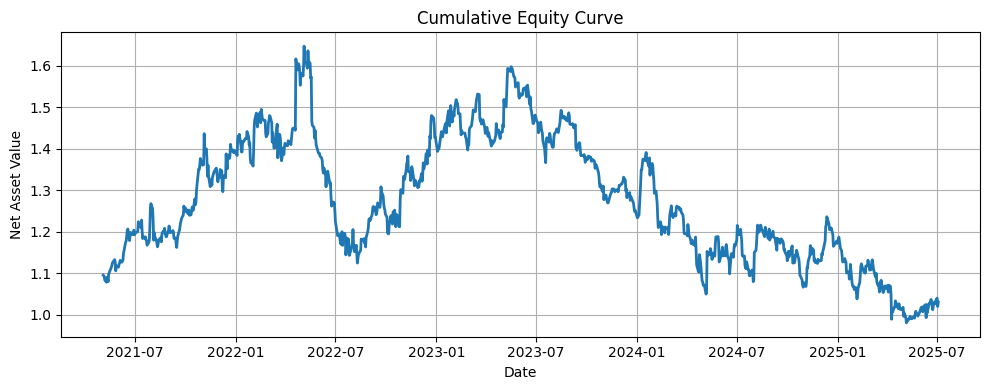

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === 读取数据 ===
df = pd.read_csv("results/daily_pnl.csv", parse_dates=["date"])
df = df.sort_values("date").reset_index(drop=True)

# === 计算简单收益（若为 log pnl）===
df["ret"] = np.exp(df["pnl"]) - 1.0

# === 净值曲线 ===
df["equity"] = (1 + df["ret"]).cumprod()

# === 性能指标计算 ===
ann_factor = 252
rf = 0.0

# 年化收益 & 波动
total_return = df["equity"].iloc[-1] - 1
ann_return = (1 + total_return) ** (ann_factor / len(df)) - 1
vol = df["ret"].std() * np.sqrt(ann_factor)

# Sharpe & Sortino
sharpe = (df["ret"].mean() - rf) / df["ret"].std() * np.sqrt(ann_factor)
sortino = (df["ret"].mean() - rf) / df.loc[df["ret"] < 0, "ret"].std() * np.sqrt(ann_factor)

# 最大回撤
roll_max = df["equity"].cummax()
drawdown = df["equity"] / roll_max - 1
max_dd = drawdown.min()

# === 打印指标 ===
print(f"Cumulative Return : {total_return:.2%}")
print(f"Annual Return     : {ann_return:.2%}")
print(f"Annual Volatility : {vol:.2%}")
print(f"Sharpe Ratio      : {sharpe:.3f}")
print(f"Sortino Ratio     : {sortino:.3f}")
print(f"Max Drawdown      : {max_dd:.2%}")

# === 画图 ===
plt.figure(figsize=(10, 4))
plt.plot(df["date"], df["equity"], label="Equity Curve", lw=2)
plt.title("Cumulative Equity Curve")
plt.xlabel("Date")
plt.ylabel("Net Asset Value")
plt.grid(True)
plt.tight_layout()
plt.savefig("results/equity_curve.png", dpi=150)
plt.show()

/tmp/ipython-input-31-2005250169.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  spy["close"] = spy["close"].fillna(method="ffill")


✅ SPY 日收益列 benchmark_ret 已写入 results/spy.csv


/tmp/ipython-input-31-2005250169.py:57: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method="ffill")


✅ 合并成功：         Date       ret  equal_ret  benchmark_ret
0 2021-05-04  0.095835   0.000000      -0.006169
1 2021-05-05 -0.001315  -0.007159       0.000313
2 2021-05-06 -0.002101   0.001857       0.007986
3 2021-05-07 -0.007647   0.009621       0.007278
4 2021-05-10 -0.004742  -0.027640      -0.009902


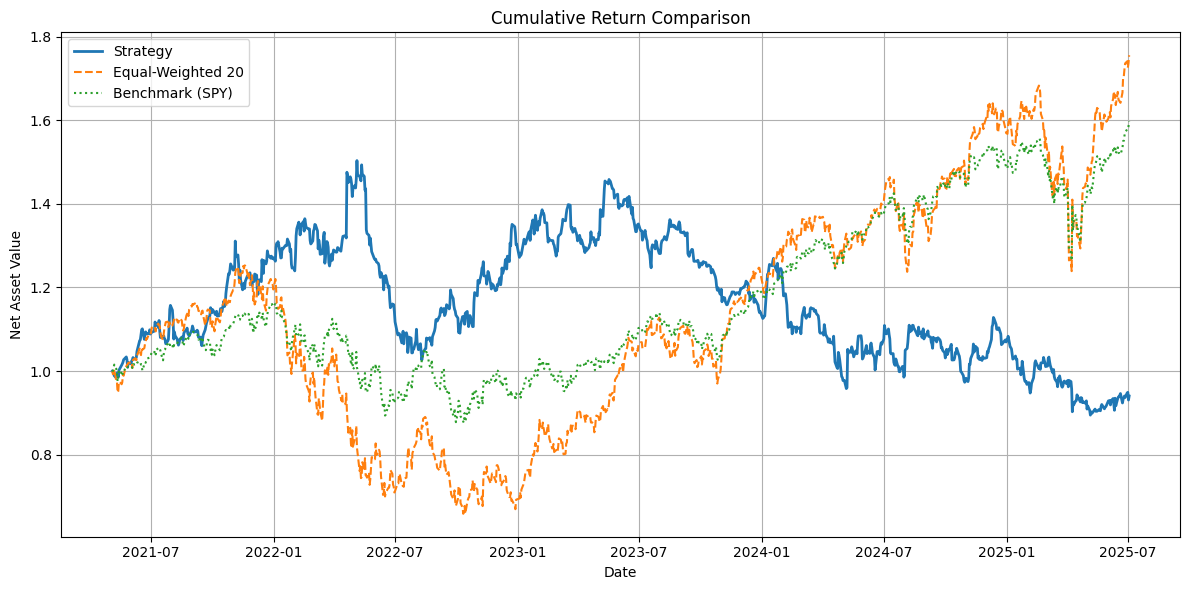

✅  图表已保存 → results/equity_compare.png

📊 Strategy
  Annual Return : 3.32%
  Annual Vol    : 22.87%
  Sharpe Ratio  : 0.145
  Sortino Ratio : 0.232
  Max Drawdown  : -40.47%

📊 Equal-20
  Annual Return : 17.50%
  Annual Vol    : 28.16%
  Sharpe Ratio  : 0.621
  Sortino Ratio : 0.890
  Max Drawdown  : -47.40%

📊 Benchmark
  Annual Return : 12.72%
  Annual Vol    : 17.90%
  Sharpe Ratio  : 0.711
  Sortino Ratio : 0.987
  Max Drawdown  : -24.50%


In [31]:
import yfinance as yf
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ───────────────────────── 0. 配置路径 ─────────────────────────
Path("results").mkdir(exist_ok=True)


# ─────────────────── 1. 处理大盘 (SPY) 数据 ───────────────────
spy_path = Path("results/spy.csv")
spy = pd.read_csv(spy_path)

# 统一列名 → Date / close
col_map = {}
for col in spy.columns:
    low = col.lower()
    if low.startswith("date"):
        col_map[col] = "Date"
    elif low.startswith(("adj", "close")):
        col_map[col] = "close"
spy = spy.rename(columns=col_map)

spy["Date"]  = pd.to_datetime(spy["Date"])
spy["close"] = pd.to_numeric(spy["close"], errors="coerce")
spy = spy.sort_values("Date").reset_index(drop=True)
spy["close"] = spy["close"].fillna(method="ffill")
spy["benchmark_ret"] = spy["close"].pct_change().fillna(0)

# 覆盖保存
spy.to_csv(spy_path, index=False)
print("✅ SPY 日收益列 benchmark_ret 已写入 results/spy.csv")

# ─────────────────── 2. 读取策略 (log pnl) ───────────────────
pnl = (pd.read_csv("results/daily_pnl.csv", parse_dates=["date"])
         .rename(columns={"date": "Date"})
         .sort_values("Date")
         .reset_index(drop=True))
pnl["ret"] = np.exp(pnl["pnl"]) - 1.0        # 若已是 simple，请改成 pnl["ret"]=pnl["pnl"]

# ─────────────────── 3. 计算等权 20 股收益 ───────────────────
TICKERS_20 = [
    "AAPL","MSFT","AMZN","GOOGL","META","TSLA","NVDA","NFLX","ORCL","INTC",
    "AMD","CRM","ADBE","QCOM","CSCO","PYPL","UBER","SHOP","BA","DIS"
]
START_DATE = pnl["Date"].min().strftime("%Y-%m-%d")

px = yf.download(TICKERS_20, start=START_DATE,
                 auto_adjust=True, progress=False)["Close"]
px = px.dropna(how="all")
equal_ret = px.pct_change().fillna(0).mean(axis=1).rename("equal_ret")

# 对齐日期并合并到 pnl
pnl = (pnl.set_index("Date")
           .join(equal_ret, how="left")
           .fillna(method="ffill")
           .reset_index())

# ─────────────────── 4. Merge 基准 & 策略 ───────────────────
df = pnl.merge(spy[["Date", "benchmark_ret"]], on="Date", how="inner")
print("✅ 合并成功：", df[["Date","ret","equal_ret","benchmark_ret"]].head())

# ───────────────────────── 5. 净值曲线 ─────────────────────────
def nav_from_ret(r):
    nav = (1 + r).cumprod()
    return nav / nav.iloc[0]          # 归一化首日 = 1
df["Strategy"]  = nav_from_ret(df["ret"])
df["Equal20"]   = nav_from_ret(df["equal_ret"])
df["Benchmark"] = nav_from_ret(df["benchmark_ret"])

# ───────────────────────── 6. 画累计收益 ─────────────────────────
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["Strategy"],  label="Strategy", lw=2)
plt.plot(df["Date"], df["Equal20"],   label="Equal-Weighted 20", ls="--")
plt.plot(df["Date"], df["Benchmark"], label="Benchmark (SPY)",   ls=":")
plt.title("Cumulative Return Comparison")
plt.xlabel("Date")
plt.ylabel("Net Asset Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("results/equity_compare.png", dpi=150)
plt.show()
print("✅  图表已保存 → results/equity_compare.png")

# ───────────────────────── 7. 性能指标 ─────────────────────────
def perf_stats(r):
    ann = 252
    ar = r.mean() * ann
    av = r.std(ddof=0) * np.sqrt(ann)
    sharpe = ar / av if av else np.nan
    downside = r[r < 0]
    sortino = ar / (downside.std(ddof=0) * np.sqrt(ann)) if len(downside) else np.nan
    nav_curve = nav(r)
    mdd = (nav_curve / nav_curve.cummax() - 1).min()
    return ar, av, sharpe, sortino, mdd

for name, col in [("Strategy", "ret"), ("Equal-20", "equal_ret"), ("Benchmark", "benchmark_ret")]:
    ar, av, sh, so, dd = perf_stats(df[col])
    print(f"\n📊 {name}")
    print(f"  Annual Return : {ar:.2%}")
    print(f"  Annual Vol    : {av:.2%}")
    print(f"  Sharpe Ratio  : {sh:.3f}")
    print(f"  Sortino Ratio : {so:.3f}")
    print(f"  Max Drawdown  : {dd:.2%}")

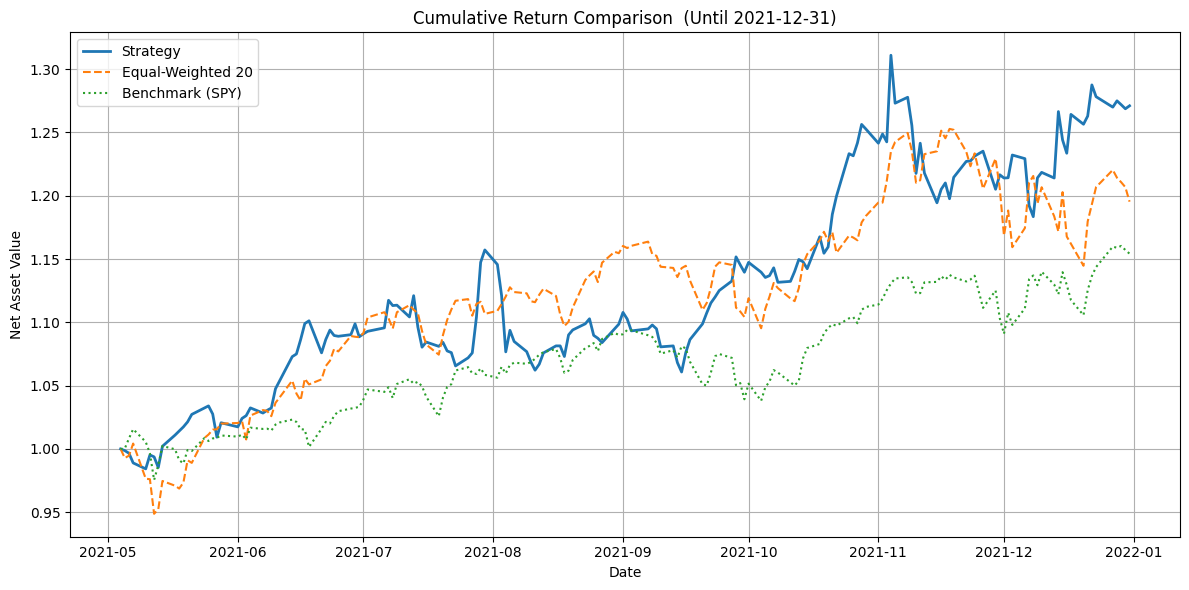


===== Performance (until 2021-12-31) =====

📊 Strategy
  Annual Return : 42.99%
  Annual Vol    : 23.11%
  Sharpe Ratio  : 1.861
  Sortino Ratio : 3.342
  Max Drawdown  : -9.73%

📊 Equal-20
  Annual Return : 30.48%
  Annual Vol    : 18.07%
  Sharpe Ratio  : 1.686
  Sortino Ratio : 2.362
  Max Drawdown  : -8.63%

📊 Benchmark
  Annual Return : 23.85%
  Annual Vol    : 12.22%
  Sharpe Ratio  : 1.951
  Sortino Ratio : 2.823
  Max Drawdown  : -5.11%


In [36]:
# ①——③ 新增：生成一个“截断版” DataFrame，并归一化首值
cutoff = pd.Timestamp("2021-12-31")
df_cut = df[df["Date"] <= cutoff].copy()
for col in ["Strategy", "Equal20", "Benchmark"]:
    df_cut[col] = df_cut[col] / df_cut[col].iloc[0]     # 起点归 1

# ④ 新增：画截断图并保存
plt.figure(figsize=(12,6))
plt.plot(df_cut["Date"], df_cut["Strategy"],  label="Strategy", lw=2)
plt.plot(df_cut["Date"], df_cut["Equal20"],   label="Equal-Weighted 20", ls="--")
plt.plot(df_cut["Date"], df_cut["Benchmark"], label="Benchmark (SPY)",   ls=":")
plt.title("Cumulative Return Comparison  (Until 2021-12-31)")
plt.xlabel("Date"); plt.ylabel("Net Asset Value")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig("results/equity_compare_until_2021.png", dpi=150)
plt.show()
# ── 截断版指标 (until 2021-12-31) ───────────────────────────
def perf_cut(r):
    """几何年化 + 最大回撤，基于 df_cut 区间"""
    ann = 252
    nav = (1 + r).cumprod()
    nav /= nav.iloc[0]                       # 起点 = 1
    days = len(r)
    ann_ret   = nav.iloc[-1] ** (ann / days) - 1
    ann_vol   = r.std(ddof=0) * np.sqrt(ann)
    sharpe    = ann_ret / ann_vol if ann_vol else np.nan
    downside  = r[r < 0]
    sortino   = ann_ret / (downside.std(ddof=0) * np.sqrt(ann)) if len(downside) else np.nan
    max_dd    = (nav / nav.cummax() - 1).min()
    return ann_ret, ann_vol, sharpe, sortino, max_dd

print("\n===== Performance (until 2021-12-31) =====")
for lbl, col in [("Strategy", "ret"),
                 ("Equal-20", "equal_ret"),
                 ("Benchmark", "benchmark_ret")]:
    ar, av, sh, so, dd = perf_cut(df_cut[col])
    print(f"\n📊 {lbl}")
    print(f"  Annual Return : {ar:.2%}")
    print(f"  Annual Vol    : {av:.2%}")
    print(f"  Sharpe Ratio  : {sh:.3f}")
    print(f"  Sortino Ratio : {so:.3f}")
    print(f"  Max Drawdown  : {dd:.2%}")

In [37]:
!pip install PyGithub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 34.3 MB/s eta 0:00:00
